<a href="https://colab.research.google.com/github/friederrr/proof_contamination/blob/main/code/CDM_eval/ensemble_and_boxplot_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**prod**
# Majority Voting and Boxplots

This notebook is used to evaluate the ensemble of methods (majority voting) and also provides the boxplot visuals from overleaf.

1) Select a model
2) This model 1 by 1 goes through each method and collects the **methodname_df**.
3) for each **methodname_df** we plot the corresponding boxplot

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install datasets

In [ ]:
import random
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import torch
import json
from datetime import datetime
import itertools
from itertools import cycle, product
import re
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from pathlib import Path
import statistics
from sklearn.model_selection import StratifiedKFold

In [ ]:
from CDMs_functions_v1 import *

## Model Selektion

**OLMO**:

- "allenai/OLMo-7B-0724-hf": Downlaod (F32): (27 GB), GPU-RAM (bfloat16): 14 GB (T4 sufficient)

- "allenai/OLMo-7B-0724-SFT-hf": Download (BF16) (14 GB), GPU-RAM (14 GB)

- "allenai/OLMo-7B-0724-Instruct-hf": Download (BF16) (14 GB), GPU-RAM (14 GB)

- "allenai/OLMo-2-1124-13B-Instruct": Download (BF16) (28 GB), GPU-RAM (27 GB) -> works fine with A100!

**DEEPSEEK**:
- "deepseek-ai/deepseek-math-7b-instruct":

**LEMMA**:
- "EleutherAI/llemma_7b"

In [ ]:
#!Parameter
model_id = "allenai/OLMo-2-1124-13B-Instruct"
short = "OL2"
DRIVE_PATH=Path('/content/drive/MyDrive/Masterarbeit25/')


#we generate the data from already generated data, if not already generated please go the the methods jupyter notebook and generate from there!
model = None
tokenizer = AutoTokenizer.from_pretrained(model_id)
ds_conta = None

### FUNCTIONS

In [ ]:
def extend_df(df, value_name, target_name, method_name, theta):

    if isinstance(theta, tuple):
        theta_a, theta_b = theta
        # Decision rule: contaminated if A_value < theta_a OR B_value > theta_b.
        y_pred = ((df[value_name[0]] < theta_a) | (df[value_name[1]] > theta_b)).astype(int).values
        df['THRESHOLD'] = str(theta)
    else:
        y_pred = (df[value_name] > theta).astype(int)
        df['THRESHOLD'] = theta


    df['PREDICTION_BINARY'] = y_pred

    df['CORRECT_PRED'] = (df['PREDICTION_BINARY'] == df[target_name]).astype(int)

    df[method_name] = df['PREDICTION_BINARY'] #(df['PREDICTION_BINARY'] == df[target_name]).astype(int) #here switch if you want true/false instead



    return df

def compute_accuracy(df):
    if 'CORRECT_PRED' not in df.columns:
        raise ValueError("DataFrame must contain 'CORRECT_PRED' column.")
    print(f"Accuracy: {df['CORRECT_PRED'].mean():.2%}")

In [ ]:
def plot_grouped_boxplot(minK_df, metric_name, title, save=False, filename=None):
    """
    Plots a grouped boxplot of a given metric by CATEGORY and LABEL ("Clean" vs "Conta").

    Parameters:
    - minK_df: pandas DataFrame containing 'CATEGORY', 'LABEL', and metric columns
    - metric_name: str, name of the column to plot on the y-axis
    - title: str, title of the plot
    - save: bool, whether to save the figure as a PDF
    - filename: str or None, name of the file to save (auto-generated if None and save=True)
    """

    # Set the style
    sns.set(style="whitegrid")

    # Define the desired order for categories
    category_order = ["word-problems", "AMC8", "AIME", "Forum"]
    minK_df['CATEGORY'] = pd.Categorical(minK_df['CATEGORY'], categories=category_order, ordered=True)

    # Define the custom color palette
    palette = {"Clean": '#1f77b4', "Conta": '#ff7f0e'}

    # Create the figure
    plt.figure(figsize=(8, 6))

    # Create the grouped boxplot
    sns.boxplot(
        data=minK_df,
        x='CATEGORY',
        y=metric_name,
        hue='LABEL',
        palette=palette,
        showfliers=False,
        dodge=True,
        width=0.4,
        linewidth=1.5
    )

    # Adjust the legend
    plt.legend(title='Status', loc='upper left')

    # Set labels and title
    plt.xlabel('Category')
    plt.ylabel(metric_name)
    plt.title(title)

    # Layout adjustment
    plt.tight_layout()

    # Save or show
    if save:
        if filename is None:
            safe_title = title.replace(' ', '_')
            filename = f"{safe_title}_{metric_name}.pdf"
        plt.savefig(filename, format='pdf')
        print(f"Plot saved as {filename}")
    else:
        plt.show()


## CDM Methods

### 1. minK

In [ ]:
dir_token_path=DRIVE_PATH / "MathCONTA_tokens"
_=list_files_in_directory(dir_token_path, model_id)

Files in /content/drive/MyDrive/Masterarbeit25/MathCONTA_tokens/allenai/OLMo-2-1124-13B-Instruct:

OLMo-2-1124-13B-Instruct/MathCONTA_token_data.json
OLMo-2-1124-13B-Instruct/MathCONTA_train_token_data.json
OLMo-2-1124-13B-Instruct/MathCONTA_test_token_data.json


In [ ]:
data_name="MathCONTA"
MathCONTA_token_data=create_mathconta_token_data(model_id=model_id,
                                                 ds_conta=ds_conta,
                                                 model=model, tokenizer=tokenizer, data_name=data_name,
                                                 only_problem=False, force_reprocess=False,
                                                 base_path_token=dir_token_path)

Loading existing token data from: /content/drive/MyDrive/Masterarbeit25/MathCONTA_tokens/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_token_data.json


In [ ]:
# best parameter
method_name="minK"
k=5
theta=0.00016
value_name='minK_value'

In [ ]:
minK_df=get_minK_df_from_tokendata(MathCONTA_token_data, k=k)

In [ ]:
minK_df=extend_df(minK_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(minK_df)
minK_df.head()

Accuracy: 64.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,k,minK_value,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,minK
0,owm-amc8-1,AMC8,Conta,1,5,0.001157,0.00016,1,1,1
1,owm-amc8-2,AMC8,Conta,1,5,0.000054,0.00016,0,0,0
2,owm-amc8-3,AMC8,Conta,1,5,0.000175,0.00016,1,1,1
3,owm-amc8-4,AMC8,Conta,1,5,0.000082,0.00016,0,0,0
4,owm-amc8-5,AMC8,Conta,1,5,0.000358,0.00016,1,1,1


Plot saved as appendix_boxplot_OL2_minK.pdf


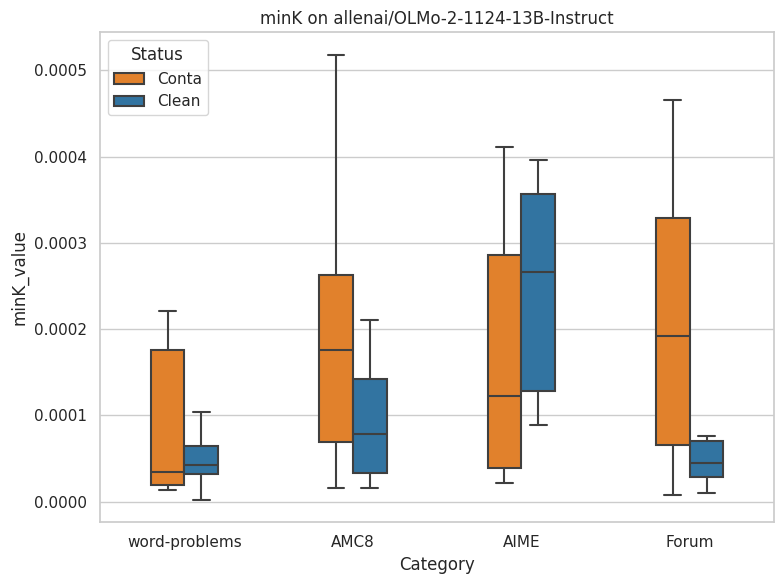

In [ ]:
plot_grouped_boxplot(minK_df,"minK_value",title="minK on "+model_id,save=True,filename=f"appendix_boxplot_{short}_minK.pdf")

### 2. Conta Traces

In [ ]:
#uses also MathCONTA_token_data

In [ ]:
# best parameter
method_name="ContaTraces"
value_name='m_value'#('A_value','B_value') #'m_value'
fit="linear" #"exponential"
theta=-0.006715 #(3.194013, 0.022786)

In [ ]:
ContaTraces_df=get_ContaTraces_df_from_tokendata(MathCONTA_token_data, fit=fit)
ContaTraces_df.head()

,ID,CATEGORY,LABEL,LABEL_BINARY,fit,m_value
0,owm-amc8-1,AMC8,Conta,1,linear,-0.004998
1,owm-amc8-2,AMC8,Conta,1,linear,-0.013626
2,owm-amc8-3,AMC8,Conta,1,linear,-0.006409
3,owm-amc8-4,AMC8,Conta,1,linear,-0.008997
4,owm-amc8-5,AMC8,Conta,1,linear,-0.005342


In [ ]:
ContaTraces_df=extend_df(ContaTraces_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(ContaTraces_df)
ContaTraces_df.head()

Accuracy: 51.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,fit,m_value,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,ContaTraces
0,owm-amc8-1,AMC8,Conta,1,linear,-0.004998,-0.006715,1,1,1
1,owm-amc8-2,AMC8,Conta,1,linear,-0.013626,-0.006715,0,0,0
2,owm-amc8-3,AMC8,Conta,1,linear,-0.006409,-0.006715,1,1,1
3,owm-amc8-4,AMC8,Conta,1,linear,-0.008997,-0.006715,0,0,0
4,owm-amc8-5,AMC8,Conta,1,linear,-0.005342,-0.006715,1,1,1


Plot saved as appendix_boxplot_OL2_ContaTraces.pdf


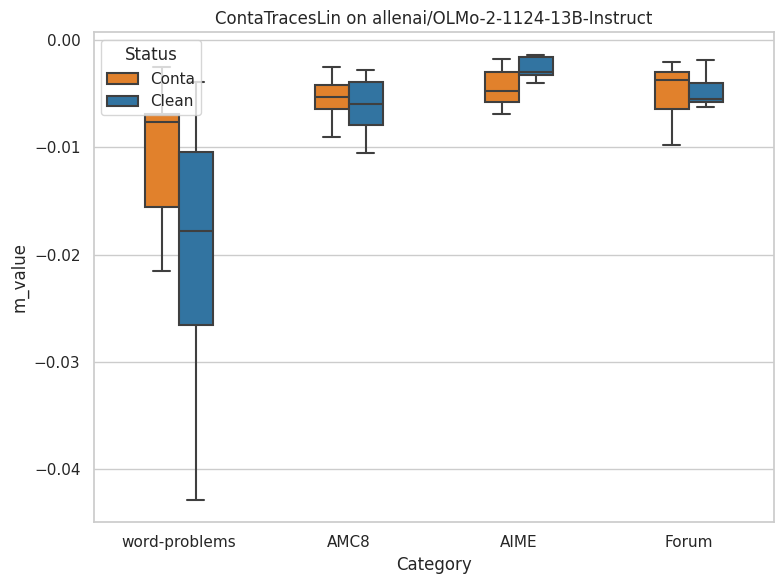

In [ ]:
#needs the ContaTrace Plot!! for exponential but nut necessarily for linear

plot_grouped_boxplot(ContaTraces_df,"m_value",title="ContaTracesLin on "+model_id,save=True,filename=f"appendix_boxplot_{short}_ContaTraces.pdf")

### 3. N-gram loglike

In [ ]:
data_name="MathCONTA_full" #please add full|problem
n_starts=20
n_range=[1,2,3,5,7]
seed_rand=42
start_offset=5
random_starts=True
force_reprocess=False
verbose=False
only_problem=False

ngram_loglike_data=create_ngram_loglike_generation_data(model_id=model_id,
                               ds_conta=ds_conta,
                                model=model, tokenizer=tokenizer,
                                 n_starts=n_starts, n=n_range, random_starts=random_starts,
                                 seed_rand=seed_rand, start_offset=start_offset, only_problem=only_problem,
                                 force_reprocess=force_reprocess, verbose=verbose,
                                 data_name=data_name, target_path=DRIVE_PATH / "MathCONTA_ngram_loglike_generation_data",
                                 base_path_token = DRIVE_PATH / "MathCONTA_tokens")

File path: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_loglike_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_nstarts20_n1_2_3_5_7.json
Loading existing n-gram loglike generation data from: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_loglike_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_nstarts20_n1_2_3_5_7.json


In [ ]:
# best parameter
method_name="ngram_ll"
value_name='ngram_loglike'
n=2
theta=-5.7918

ngram_loglike_df=get_ngram_loglike_df_from_generation_data(ngram_loglike_data, n=n)

In [ ]:
ngram_loglike_df=extend_df(ngram_loglike_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(ngram_loglike_df)
ngram_loglike_df.head()

Accuracy: 56.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,n,ngram_loglike,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,ngram_ll
0,owm-amc8-1,AMC8,Conta,1,2,-2.835959,-5.7918,1,1,1
1,owm-amc8-2,AMC8,Conta,1,2,-3.453806,-5.7918,1,1,1
2,owm-amc8-3,AMC8,Conta,1,2,-1.735426,-5.7918,1,1,1
3,owm-amc8-4,AMC8,Conta,1,2,-3.876361,-5.7918,1,1,1
4,owm-amc8-5,AMC8,Conta,1,2,-2.663177,-5.7918,1,1,1


Plot saved as appendix_boxplot_OL2_ngramll.pdf


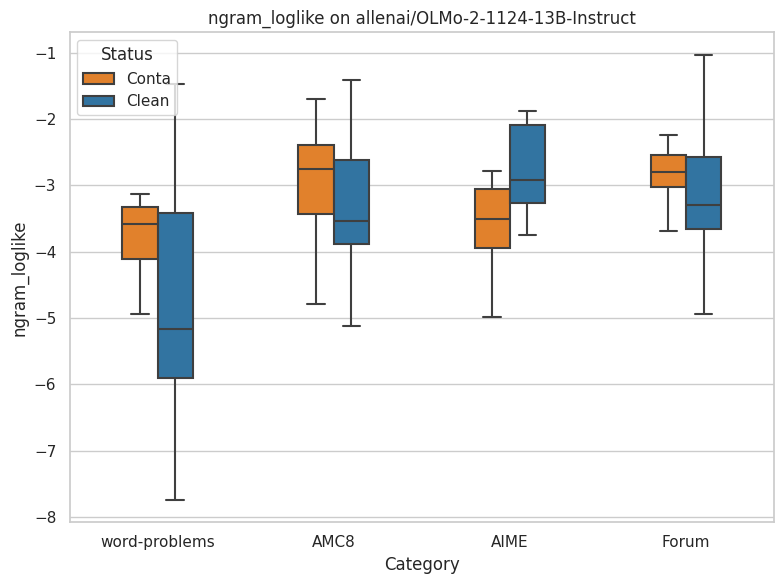

In [ ]:
plot_grouped_boxplot(ngram_loglike_df,"ngram_loglike",title="ngram_loglike on "+model_id,save=True,filename=f"appendix_boxplot_{short}_ngramll.pdf")

### 4. CDD

In [ ]:
dir_token_path=DRIVE_PATH / "MathCONTA_cdd_generation_data"

In [ ]:
data_name="MathCONTA"
MathCONTA_cdd_data=create_cdd_generation_data(model_id=model_id,
                                                 ds_conta=ds_conta,
                                                 model=model, tokenizer=tokenizer, data_name=data_name,
                                                force_reprocess=False,max_new_tokens=200,sample_size=50,
                                                 base_path_token=dir_token_path,verbose=False)

Loading existing cdd generation data from: /content/drive/MyDrive/Masterarbeit25/MathCONTA_cdd_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_sample50_max200_seed42.json


In [ ]:
# best parameter
method_name="cdd"
value_name='cdd_value'
alpha=0.3
theta=0

cdd_df=get_cdd_df_from_generation_data(MathCONTA_cdd_data, alpha=alpha)

In [ ]:
cdd_df=extend_df(cdd_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(cdd_df)
cdd_df.head()

Accuracy: 51.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,alpha,cdd_value,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,cdd
0,owm-forum-1,Forum,Conta,1,0.3,0.0,0,0,0,0
1,owm-forum-2,Forum,Conta,1,0.3,0.0,0,0,0,0
2,owm-forum-3,Forum,Conta,1,0.3,0.0,0,0,0,0
3,owm-forum-4,Forum,Conta,1,0.3,0.0,0,0,0,0
4,owm-forum-5,Forum,Conta,1,0.3,0.0,0,0,0,0


Plot saved as appendix_boxplot_OL2_cdd.pdf


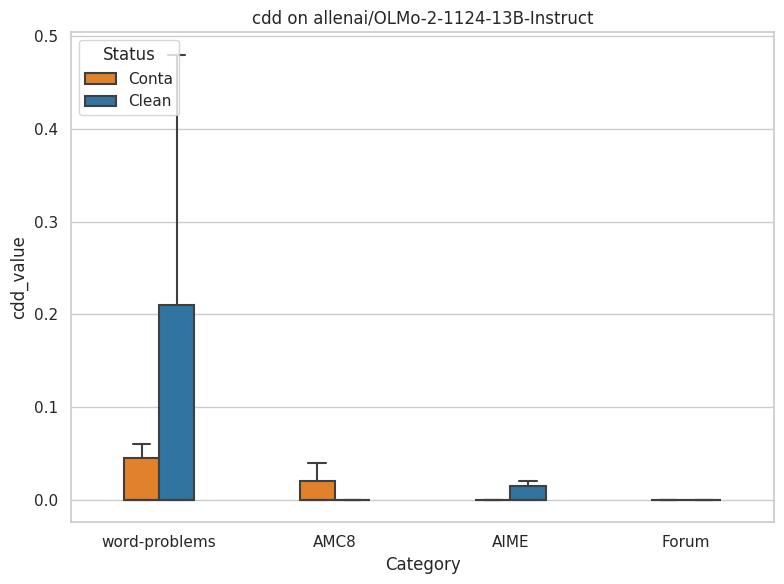

In [ ]:
plot_grouped_boxplot(cdd_df,"cdd_value",title="cdd on "+model_id,save=True,filename=f"appendix_boxplot_{short}_cdd.pdf")

### 5. N-gram accuracy

In [ ]:
dir_token_path=DRIVE_PATH / "MathCONTA_ngram_generation_data"

data_name="MathCONTA_full_temp0" #please add full|problem and tempx to the name: e.g. AIME_full_temp0
n_starts=20
n_range=[1,2,3,5,7]
temp=0.0
torch_seed=42
seed_rand=42
start_offset=5
random_starts=True
only_problem=False
force_reprocess=False
verbose=False
data=None

MathCONTA_ngram_data=create_ngram_generation_data(model_id=model_id,ds_conta=data,
                                                 model=model, tokenizer=tokenizer, data_name=data_name,
                                                force_reprocess=force_reprocess,n_starts=n_starts,n=n_range,temp=temp,
                                                 torch_seed=torch_seed,seed_rand=seed_rand,start_offset=start_offset,random_starts=random_starts,
                                                 only_problem=only_problem,verbose=verbose,
                                                 base_path_token=dir_token_path)

File path: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_temp0_nstarts20_n1_2_3_5_7_seed42.json
Loading existing n-gram generation data from: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_temp0_nstarts20_n1_2_3_5_7_seed42.json


In [ ]:
method_name="ngram_ac" #sic! ngram_ac
value_name='ngram_acc'
n=1
theta=0.625

ngram_df=get_ngram_df_from_generation_data(MathCONTA_ngram_data, n=n)

In [ ]:
ngram_df=extend_df(ngram_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(ngram_df)
ngram_df.head()

Accuracy: 49.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,n,ngram_acc,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,ngram_ac
0,owm-forum-1,Forum,Conta,1,1,0.8,0.625,1,1,1
1,owm-forum-2,Forum,Conta,1,1,0.7,0.625,1,1,1
2,owm-forum-3,Forum,Conta,1,1,0.7,0.625,1,1,1
3,owm-forum-4,Forum,Conta,1,1,0.5,0.625,0,0,0
4,owm-forum-5,Forum,Conta,1,1,0.8,0.625,1,1,1


Plot saved as appendix_boxplot_OL2_ngram_acc.pdf


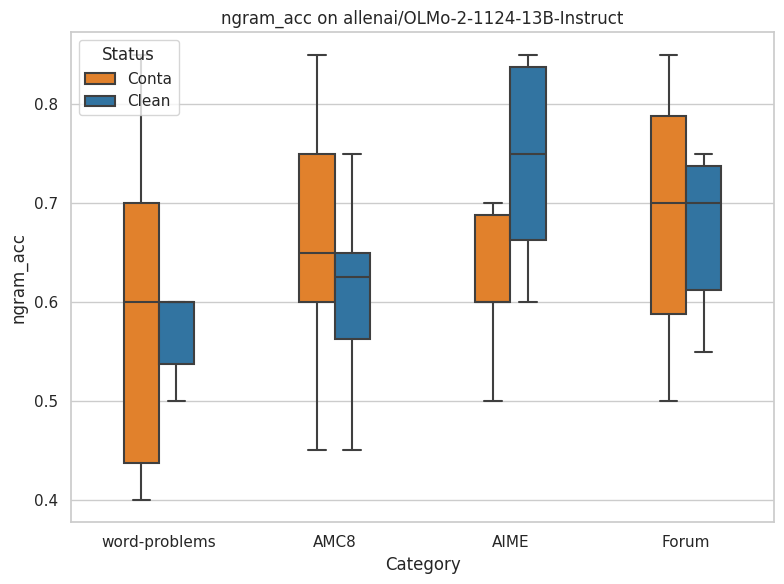

In [ ]:
plot_grouped_boxplot(ngram_df,"ngram_acc",title="ngram_acc on "+model_id,save=True,filename=f"appendix_boxplot_{short}_ngram_acc.pdf")

### 6. N-gram CDD

In [ ]:
model_config = {
    "model_id": model_id,
    "model": model,
    "tokenizer": tokenizer,
    "torch_seed": 42,
}

method_config = {
    "n_starts": 3,
    "sample_size": 50,
    "n_range": [10,20,30],
    "random_starts": False,
    "seed_rand": 42,
    "start_offset": 10,
    "verbose": False,

}

data_config = {
    "ds_conta": ds_conta,
    "only_problem": False,
    "force_reprocess": False,
    "data_name": "MathCONTA_full",
    "base_path_generation": DRIVE_PATH / "MathCONTA_ngram_cdd_generation_data"
}

In [ ]:
ngram_cdd_data=create_ngram_cdd_generation_data(**model_config, **method_config, **data_config)

File path: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_cdd_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_nstarts3_n10_20_30_sample50.json
Loading existing n-gram generation data from: /content/drive/MyDrive/Masterarbeit25/MathCONTA_ngram_cdd_generation_data/allenai/OLMo-2-1124-13B-Instruct/MathCONTA_full_nstarts3_n10_20_30_sample50.json


In [ ]:
# best parameter
method_name="ngram_cdd"
value_name='ngram_cdd_mean'
n=10
alpha=0.3
theta=0.056

ngram_cdd_df=get_ngram_cdd_df_from_generation_data(ngram_cdd_data,n,alpha)

In [ ]:
ngram_cdd_df=extend_df(ngram_cdd_df, value_name=value_name, target_name='LABEL_BINARY', method_name=method_name, theta=theta)
compute_accuracy(ngram_cdd_df)
ngram_cdd_df.head()

Accuracy: 54.00%


,ID,CATEGORY,LABEL,LABEL_BINARY,n,alpha,ngram_cdd_mean,THRESHOLD,PREDICTION_BINARY,CORRECT_PRED,ngram_cdd
0,owm-word-1,word-problems,Conta,1,10,0.3,0.160000,0.056,1,1,1
1,clean-word-1,word-problems,Clean,0,10,0.3,0.206667,0.056,1,0,1
2,owm-word-2,word-problems,Conta,1,10,0.3,0.106667,0.056,1,1,1
3,clean-word-2,word-problems,Clean,0,10,0.3,0.033333,0.056,0,1,0
4,owm-word-3,word-problems,Conta,1,10,0.3,0.173333,0.056,1,1,1


Plot saved as appendix_boxplot_OL2_ngram_cdd.pdf


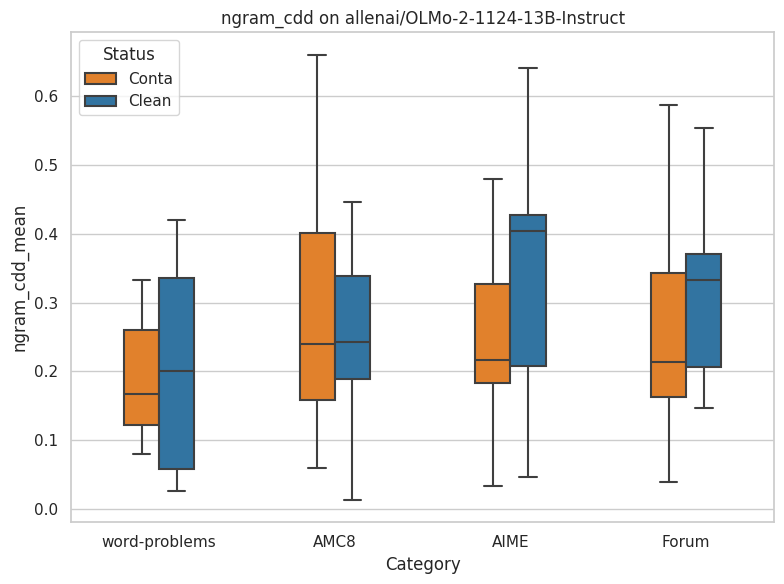

In [ ]:
plot_grouped_boxplot(ngram_cdd_df,"ngram_cdd_mean",title="ngram_cdd on "+model_id,save=True,filename=f"appendix_boxplot_{short}_ngram_cdd.pdf")

## Combine all of them

In [ ]:
#be careful ngram_ll is the right value in ngram_loglike_df

In [ ]:
from functools import reduce
import pandas as pd

def join_selected_columns_on_id(dfs, dfs_columns):
    # Keep only 'ID' and the desired column from each df
    reduced_dfs = [
        df[['ID', col_name]]
        for df, col_name in zip(dfs, dfs_columns)
    ]

    # Merge on 'ID'
    merged_df = reduce(lambda left, right: pd.merge(left, right, on='ID', how='inner'), reduced_dfs)

    return merged_df

In [ ]:
dfs= [minK_df, ContaTraces_df, ngram_loglike_df, cdd_df, ngram_df, ngram_cdd_df]
dfs_columns= ["minK", "ContaTraces", "ngram_ll", "cdd", "ngram_ac", "ngram_cdd"]

In [ ]:
merged_df = join_selected_columns_on_id(dfs, dfs_columns)
merged_df

,ID,minK,ContaTraces,ngram_ll,cdd,ngram_ac,ngram_cdd
0,owm-amc8-9,1,1,1,1,1,1
1,owm-amc8-10,1,1,1,0,1,1
2,owm-amc8-12,0,1,1,0,1,1
3,owm-amc8-15,0,1,1,0,1,1
4,owm-amc8-17,0,0,1,0,1,1
5,clean-amc8-1,0,0,1,0,1,1
6,clean-amc8-3,0,1,1,0,1,1
7,clean-amc8-10,0,1,1,0,1,1
8,clean-amc8-14,1,1,0,1,1,1
9,clean-amc8-18,1,0,1,0,1,1


## VISUALIERUNGEN

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_binary_heatmap(merged_df):
    # Set 'ID' as index if it's not already
    if merged_df.index.name != 'ID':
        df = merged_df.set_index('ID')
    else:
        df = merged_df

    plt.figure(figsize=(5, 10))  # Adjust size as needed
    sns.heatmap(df, cmap=['black', 'white'], cbar=False, linewidths=0.5, linecolor='gray')
    plt.title(f'{model_id}', fontsize=14)
    plt.xlabel('Features')
    plt.ylabel('ID')
    plt.tight_layout()
    plt.show()


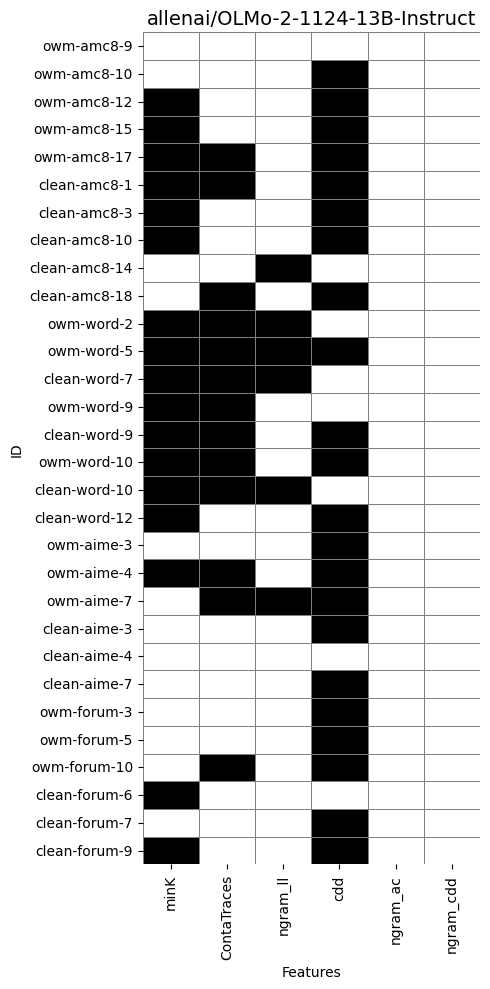

In [ ]:
plot_binary_heatmap(merged_df)

### Potenzial des Majority-Votings (yes!) Das war auf den ganzen Datensatz (auf Test gilt das nicht mehr!)

### Beschreibung:
Achtung angezeigt werden die "richtigen" Vorhersagen. Schwarz ist Fasche Vorhersage. Beispiel wenn bei conta ein feld schwarz ist, dann wurde hier clean vorhergesagt.

Was auf den ersten blick auffällt ist dass alle whitebox methoden sehr korreliert sind.

Ziehmlich konträr ist CDD, fast immer richtig wenn minK versagt und umgekehrt. Könnte Zufall sein, aber man muss das weiter untersuchen!

Eventuell lässt sich da was ausnutzen! Oder es hat etwas mit der Schwierigkeit der Fragen zu tun?



Wie jetzt methodisch weiter: mit den besten parameter gehen wir weiter (mean_tresholds) reporten die train_set accuracy, dadurch können wir das Potenzial eines majority voting approaches herausfinden. Hier geht es um den Gain an Performance (die endgültige Peformance) ist dann aber nicht zu generalisieren (train_set accuracy).Könnte man machen! (Einfach also Potenzial Analyse!).

[Oder man macht nested crossvalidation, bedeutet 2 CV schleifen - derzeit nicht geplant, außer es wird explizit gefordert!!]

In [ ]:
## Punkt aus für Masterarbeit gibt es einfach nur 100 Beispiele und kein nested CV (außer es wird explizit gefordert!)

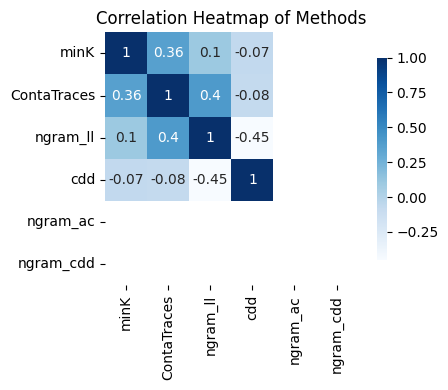

In [ ]:
# Compute correlation matrix
if merged_df.index.name != 'ID':
    df = merged_df.set_index('ID')
else:
    df = merged_df
corr_matrix = df.corr().round(2)

# Plot correlation heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Methods')
plt.tight_layout()
plt.show()

In [ ]:
## Interpreation, Because of low correlation -> Ensemble methods might have potential theoretically. But as all of them are around random guessing, the results are arcordingly bad

## Evaluation
1. we need LabelBINARY back
2. and a prediction column
3. adjust evaluate_method_standard -> make a ensemble branch

In [ ]:
merged_df_2eval = pd.merge(minK_df[['ID','LABEL_BINARY']], merged_df, on='ID', how='inner')

def majority_vote(row):
    methods = ["minK", "ContaTraces", "ngram_ll", "cdd", "ngram_ac", "ngram_cdd"]
    votes = [row[m] for m in methods]
    ones = votes.count(1)
    zeros = len(votes) - ones
    return random.choice([0, 1]) if ones == zeros else int(ones > zeros)

merged_df_2eval["PREDICTION_BINARY"] = merged_df_2eval.apply(majority_vote, axis=1)

In [ ]:
log_path_base =DRIVE_PATH / "cdm_data" / "MathCONTA_v1"
exp_id = "overleaf2"
data_name="MathCONTA_full_test"

# method_name must contain ensemble !!
method_name="Ensemble"

# theta here used to shortly describe ensemble method
theta = "majority_voting_random_tie"

# metric_col here PREDICTION_BINARY (will )
metric_col="PREDICTION_BINARY"


log_dict=evaluate_method_standard(merged_df_2eval, metric_col=metric_col, data_name=data_name, theta=theta,
                         model_id=model_id, method_name=method_name)
log_dict

{'model_id': 'allenai/OLMo-2-1124-13B-Instruct',
 'data_name': 'MathCONTA_full_test',
 'datetime': '2025-04-13T13:21:46.637659',
 'method_name': 'Ensemble',
 'parameter': {'parameter1': None,
  'parameter2': None,
  'theta': 'majority_voting_random_tie'},
 'metrics': {'accuracy': 0.4666666666666667,
  'accuracy_95CI': (0.3, 0.6666666666666666),
  'precision': 0.4782608695652174,
  'recall': 0.7333333333333333,
  'f1_score': 0.5789473684210527,
  'confusion_matrix': [[3, 12], [4, 11]],
  'mcnemar_b': 3,
  'mcnemar_c': 4,
  'mcnemar_p_value': 1.0},
 'n_bootstrap': 1000,
 'seed': 42}

In [ ]:
save_accuracy_log(log_path_base=log_path_base, model_id=model_id, method_name=method_name, exp_id=exp_id, data_name=data_name,out_dict=log_dict)

Accuracy log saved in /content/drive/MyDrive/Masterarbeit25/cdm_data/MathCONTA_v1/allenai/OLMo-7B-0724-Instruct-hf/Ensemble/MathCONTA_full_test_accuracylog_overleaf2.json
